In [24]:
! pip install torch torchvision pillow numpy matplotlib


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

content_img_path = 'Pictures/Pic1.jpg'
style_img_path = 'Pictures/Pic2.jpg'

In [26]:
def load_image(img_path, max_size=512):
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"Cannot find image file: {img_path}")
        
    image = Image.open(img_path).convert('RGB')
    print(f"Loaded image: {img_path}, size: {image.size}")
    
    if max(image.size) > max_size:
        size = max_size
        if image.width > image.height:
            size = (max_size, int(image.height * max_size / image.width))
        else:
            size = (int(image.width * max_size / image.height), max_size)
        image = image.resize(size, Image.LANCZOS)
        print(f"Resized to: {size}")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)
    return img_tensor, image.size

In [27]:
def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    return image

In [28]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a, b, c * d)
    G = torch.bmm(features, features.transpose(1, 2))
    return G.div(b * c * d)

In [29]:
def run_neural_style_transfer(content_img, style_img, num_steps=300):
    input_img = content_img.clone().requires_grad_(True)
    
    style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
    content_layers = ['conv4_2']
    
    vgg = models.vgg19(pretrained=True).features.to(device).eval()
    
    def get_features(x, model, layers):
        features = {}
        layer_names = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }
        
        for name, layer in enumerate(model):
            x = layer(x)
            if str(name) in layer_names and layer_names[str(name)] in layers:
                features[layer_names[str(name)]] = x
                
        return features
    
    style_features = get_features(style_img, vgg, style_layers)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    content_features = get_features(content_img, vgg, content_layers)
    
    optimizer = torch.optim.LBFGS([input_img])
    
    style_weight = 1000000
    content_weight = 1
    
    num_steps = 100
    
    for step in range(num_steps):
        def closure():
            optimizer.zero_grad()
            
            features = get_features(input_img, vgg, style_layers + content_layers)
            
            content_loss = torch.mean((features[content_layers[0]] - content_features[content_layers[0]]) ** 2)
            
            style_loss = 0
            for layer in style_layers:
                if layer in features:
                    current_gram = gram_matrix(features[layer])
                    style_loss += torch.mean((current_gram - style_grams[layer]) ** 2)
            
            total_loss = content_weight * content_loss + style_weight * style_loss
            
            total_loss.backward()
            
            if step % 20 == 0:
                print(f"Step {step}, Total loss: {total_loss.item()}")
            
            return total_loss
        
        optimizer.step(closure)
    
    return input_img

In [30]:
def save_image(tensor, filename):
    image = tensor_to_image(tensor)
    image = (image * 255).astype(np.uint8)
    Image.fromarray(image).save(filename)

Attempting to load content image...
Loaded image: Pictures/Pic1.jpg, size: (640, 954)
Resized to: (343, 512)
Content image loaded successfully.
Attempting to load style image...
Loaded image: Pictures/Pic2.jpg, size: (2000, 1594)
Resized to: (512, 408)
Style image loaded successfully.


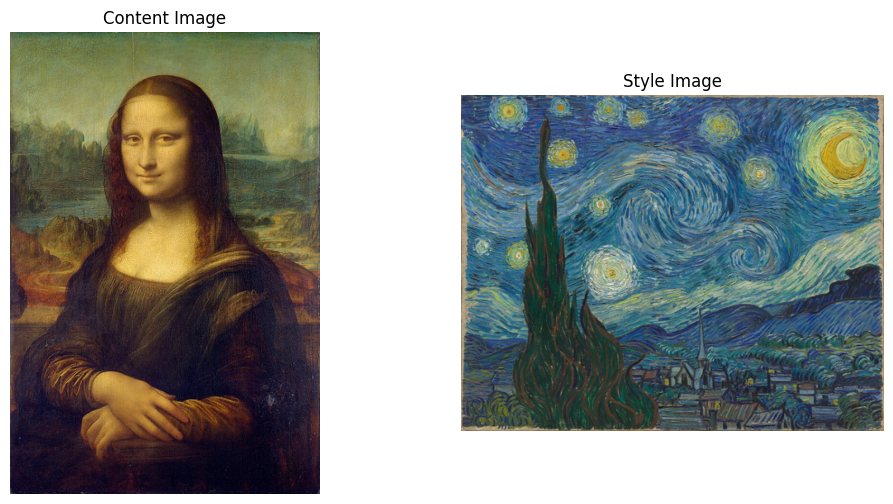

Running Neural Style Transfer...
Step 0, Total loss: 9.84522819519043
Step 0, Total loss: 9.842787742614746
Step 0, Total loss: 6.637056350708008
Step 0, Total loss: 4.439937591552734
Step 0, Total loss: 3.682466506958008
Step 0, Total loss: 3.0206265449523926
Step 0, Total loss: 2.3764729499816895
Step 0, Total loss: 2.2444586753845215
Step 0, Total loss: 1.9489967823028564
Step 0, Total loss: 1.7237193584442139
Step 0, Total loss: 1.6055878400802612
Step 0, Total loss: 1.5168646574020386
Step 0, Total loss: 1.4514498710632324
Step 0, Total loss: 1.3675793409347534
Step 0, Total loss: 1.3108532428741455
Step 0, Total loss: 1.2696856260299683
Step 0, Total loss: 1.2340595722198486
Step 0, Total loss: 1.2061550617218018
Step 0, Total loss: 1.177837610244751
Step 0, Total loss: 1.1641738414764404
Step 20, Total loss: 0.6317121386528015
Step 20, Total loss: 0.6316660046577454
Step 20, Total loss: 0.6316171288490295
Step 20, Total loss: 0.6315709352493286
Step 20, Total loss: 0.63152515888

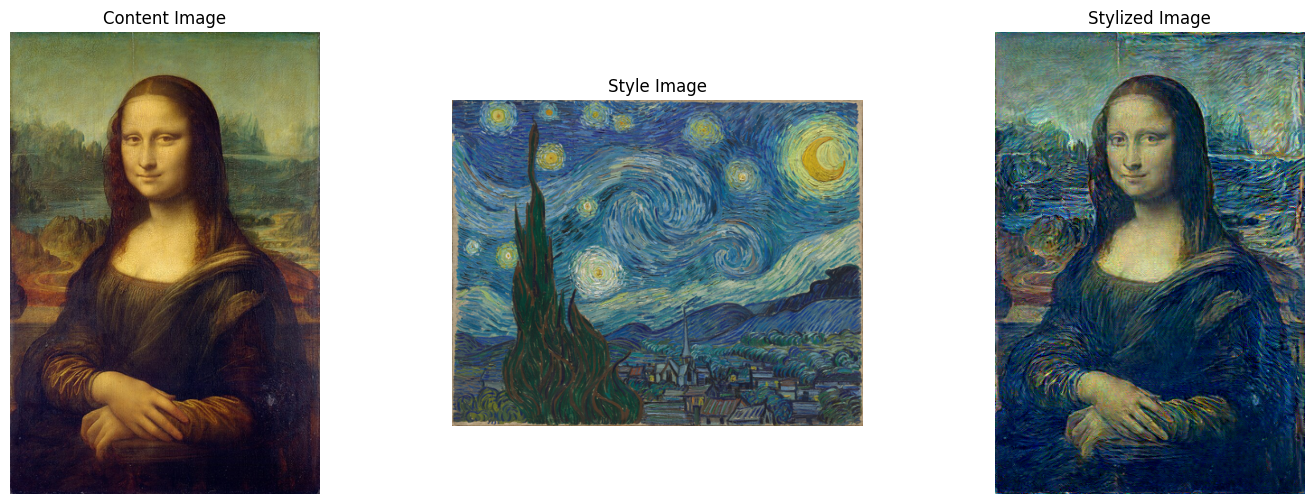

Stylized image saved as 'stylized_output.jpg'


In [31]:
try:
    print("Attempting to load content image...")
    content_tensor, content_size = load_image(content_img_path)
    print("Content image loaded successfully.")
    
    print("Attempting to load style image...")
    style_tensor, style_size = load_image(style_img_path)
    print("Style image loaded successfully.")
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(tensor_to_image(content_tensor))
    plt.title('Content Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(tensor_to_image(style_tensor))
    plt.title('Style Image')
    plt.axis('off')
    plt.show()
    
    print("Running Neural Style Transfer...")
    with torch.no_grad():
        stylized_image = run_neural_style_transfer(content_tensor, style_tensor, num_steps=100)
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(tensor_to_image(content_tensor))
    plt.title('Content Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(tensor_to_image(style_tensor))
    plt.title('Style Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(tensor_to_image(stylized_image))
    plt.title('Stylized Image')
    plt.axis('off')
    plt.show()
    
    save_image(stylized_image, 'stylized_output.jpg')
    print("Stylized image saved as 'stylized_output.jpg'")
    
except Exception as e:
    print(f"Error: {e}")
    
    print("\nTrying alternative approach with TorchVision's pretrained transformer...")
    
    try:
        content_img = Image.open(content_img_path).convert('RGB')
        style_img = Image.open(style_img_path).convert('RGB')
        
        size = (512, 512)
        content_img = content_img.resize(size, Image.LANCZOS)
        style_img = style_img.resize(size, Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
        content_tensor = transform(content_img).unsqueeze(0).to(device)
        style_tensor = transform(style_img).unsqueeze(0).to(device)
        
        def simple_style_transfer(content, style, num_steps=100):
            input_img = content.clone().requires_grad_(True)
            
            optimizer = torch.optim.Adam([input_img], lr=0.01)
            
            model = models.vgg16(pretrained=True).features[:16].to(device).eval()
            
            for step in range(num_steps):
                content_features = model(content)
                style_features = model(style)
                input_features = model(input_img)
                
                content_loss = F.mse_loss(input_features, content_features)
                
                mean_loss = F.mse_loss(
                    torch.mean(input_features, dim=[2, 3]), 
                    torch.mean(style_features, dim=[2, 3])
                )
                std_loss = F.mse_loss(
                    torch.std(input_features, dim=[2, 3]), 
                    torch.std(style_features, dim=[2, 3])
                )
                
                style_loss = mean_loss + std_loss
                
                loss = content_loss + 1000 * style_loss
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                input_img.data.clamp_(0, 1)
                
                if step % 10 == 0:
                    print(f"Step {step}, Loss: {loss.item()}")
            
            return input_img
        
        stylized_image = simple_style_transfer(content_tensor, style_tensor)
        
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(content_tensor.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        plt.title('Content Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(style_tensor.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        plt.title('Style Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(stylized_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))
        plt.title('Stylized Image')
        plt.axis('off')
        plt.show()
        
        stylized_np = stylized_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
        stylized_np = np.clip(stylized_np * 255, 0, 255).astype(np.uint8)
        Image.fromarray(stylized_np).save('stylized_output_alternative.jpg')
        print("Stylized image saved as 'stylized_output_alternative.jpg'")
        
    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")
        print("\nPlease check the image paths and ensure they exist.")